# $t\bar{t}$ plots

**Goal:** I want to have the right diagnositics to understand what's going on with the new proposal for including $t\bar{t}$ bits in our background estimate.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoLocator, AutoMinorLocator, MultipleLocator,FixedLocator, LogLocator

from crypto_utils import *

import os
from glob import glob

os.sys.path += ['../non-resonant-studies', "../PyATLASstyle/", "../stats-results/"]

from quad45_2x2 import res_bin_edges

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Using uproot4


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Step 1:** Set up a table to look at these SFs in

In [2]:
bcat = '4b'

In [3]:
idx = ['pre cr','post cr','pre vr','post vr','extrap norm (new)','extrap norm (naive)','res style norm']
cols = pd.MultiIndex.from_product([[16, 17, 18],['semi-lep','all-had','QCD']])

In [4]:
sfs = pd.DataFrame(0, index=idx, columns=cols)

In [5]:
sfs

16                   17                   18  \
                    semi-lep all-had QCD semi-lep all-had QCD semi-lep   
pre cr                     0       0   0        0       0   0        0   
post cr                    0       0   0        0       0   0        0   
pre vr                     0       0   0        0       0   0        0   
post vr                    0       0   0        0       0   0        0   
extrap norm (new)          0       0   0        0       0   0        0   
extrap norm (naive)        0       0   0        0       0   0        0   
res style norm             0       0   0        0       0   0        0   

                                 
                    all-had QCD  
pre cr                    0   0  
post cr                   0   0  
pre vr                    0   0  
post vr                   0   0  
extrap norm (new)         0   0  
extrap norm (naive)       0   0  
res style norm            0   0

In [6]:
alpha_2b = pd.DataFrame(0, index=['cr','vr'], columns=[16,17,18])

In [7]:
inDir = '../stats-results/ttbarStudies/'

In [8]:
for yr in [16,17,18]:
    
    # Load in the histograms which make the fit pieces
    with open(f'{inDir}/fitCRs_{yr}_{bcat}.json') as fi:
        hist_dict = json.load(fi)
    
        for k in hist_dict.keys():
            hist_dict[k] = np.array(hist_dict[k])
    
    ps = {}
    
    for ri,ti in zip(['cr','vr'],['','_vr']):
        preEst =  np.array(hist_dict[f'sl_{ri}_{bcat}']) + np.array(hist_dict[f'ah_{ri}_{bcat}']) \
                + np.array(hist_dict[f'qcd_{ri}_rw_to_{bcat}{ti}']) 
        sfs.loc[f'pre {ri}',yr] = np.array(hist_dict['dat_cr_4b']) / preEst

        p, cov, alpha_2b_i = getFit(hist_dict,region=ri,target=bcat,train=ti)

        err = np.sqrt(np.diag(cov))
        
        sfs.loc[f'post {ri}',yr] = [f'{pi:1.2f} $\pm$ {ei:1.2f}' for pi,ei in zip(p, err)]
        alpha_2b.loc[ri, yr] = alpha_2b_i

        ps[ri] = p
        
    sfs.loc[f'extrap norm (new)',yr] = ps['vr'] / ps['cr']


In [9]:
bcat_to_label = {
    '4b': '4b',
    '3b1l': '3b + 1 loose',
    '3b1f': '3b + 1 fail'
}

In [10]:
figDir = 'figures/ttbar/rings/'

In [11]:
def fitsAllYrs(hist_dict,region='cr',target='3b1f',train='',
               rlim1=(.9,1.1),rlim2=(.9,1.1),show_rw=False,figDir=''):
    '''
    Compare the pre and post-fit ttbar yields plots for all of the years
    '''
    
    lw=2.5
    e = np.arange(-.5,3,1)
    labels = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd est']
    colors = ['dodgerblue','limegreen','gold']
    
    fig, axes = plt.subplots(4,3,figsize=(18, 12), #sharex=True,
                             gridspec_kw={"height_ratios": [1/3,1/6,1/3,1/6],
                                          "width_ratios": [1/3,1/3,1/3],
                                          "wspace" : 0.25, #"hspace":0.4,
                                          "left":0.1, "bottom":.25}
                            )

    
    for yr,ax_col in zip([16,17,18],axes.T):
    
        # Load in the histograms which make the fit pieces
        with open(f'{inDir}/fitCRs_{yr}_{bcat}.json') as fi:
            hist_dict = json.load(fi)

            for k in hist_dict.keys():
                hist_dict[k] = np.array(hist_dict[k])
    
        # Get the fits
        p_i, cov_i, alpha_2b_i = getFit(hist_dict,region=region,target=target,train=train)

        err = np.sqrt(np.diag(cov_i))
    
        keys = [f'sl_{region}_{target}',f'ah_{region}_{target}',f'qcd_{region}_rw_to_{target}{train}']
        hists = [hist_dict[k] for k in keys]

        for p,opt,rlim,ax1,ax2 in zip([np.ones(3),p_i],['pre','post'],[rlim1,rlim2],
                                      [ax_col[0],ax_col[2]],[ax_col[1],ax_col[3]]):
            
            prev = 0
            for h,pi,c,l in zip(hists,p,colors,labels):

                ax1.hist(range(3),e, weights=pi*h,bottom=prev,color=c,label=l)
                prev+=pi*h

            y = hist_dict[f'dat_{region}_{target}']
            ax1.errorbar(range(3),y,np.sqrt(y),.5,lw=0,elinewidth=lw,
                           color='k',marker='o',label=bcat_to_label[target])

            # And the ratio panel
            pred = np.vstack(p.reshape(-1,1)*hists).sum(axis=0)

            ax2.errorbar(range(3),y/pred, np.sqrt(y)/pred,.5,
                           lw=0,elinewidth=lw,color='k',marker='o')

            if show_rw:
                rw = hist_dict[f'dat_{region}_rw_to_{target}']
                ax1.plot(range(3),rw,color='deeppink',lw=0,marker='s')
                ax2.plot(range(3),rw/pred,color='deeppink',lw=0,marker='s')

            if opt=='post':
                # Hatched line for the error on the prediction
                ax2.fill_between(e,np.append(0,1-err), np.append(0,1+err),step="pre", 
                                   facecolor='None',edgecolor='dimgrey', hatch='\\\\\\\\',lw=0)            

            ax1.text(.39,.9,f'20{yr} {region.upper()}\n{opt}-fit',transform=ax1.transAxes,
                       ha='left',va='top',fontsize=17)

            ax1.set_ylabel('Entries',ha='right',y=1,fontsize=15)
            ax2.set_ylabel(f'{target} / pred',fontsize=15)

            ax1.legend(fontsize=12)
            
            for ax in [ax1,ax2]: 
                ax.set_xticks(range(3))
                ax.set_xlim(e[0],e[-1])
                ax.tick_params('x',which='minor',length=0)
            
                
            ax2.set_xticklabels(['iso $\mu$','$X_{wt}$ < 0.75','$X_{wt}$ > 0.75'])
            ax2.plot([e[0],e[-1]],[1]*2,'k',ls='dotted',lw=lw)
            ax2.set_ylim(rlim)

    
    if figDir:
        plt.savefig(f'{figDir}/prePostFit-{region}-16-17-18_{bcat}.pdf', bbox_inches='tight')


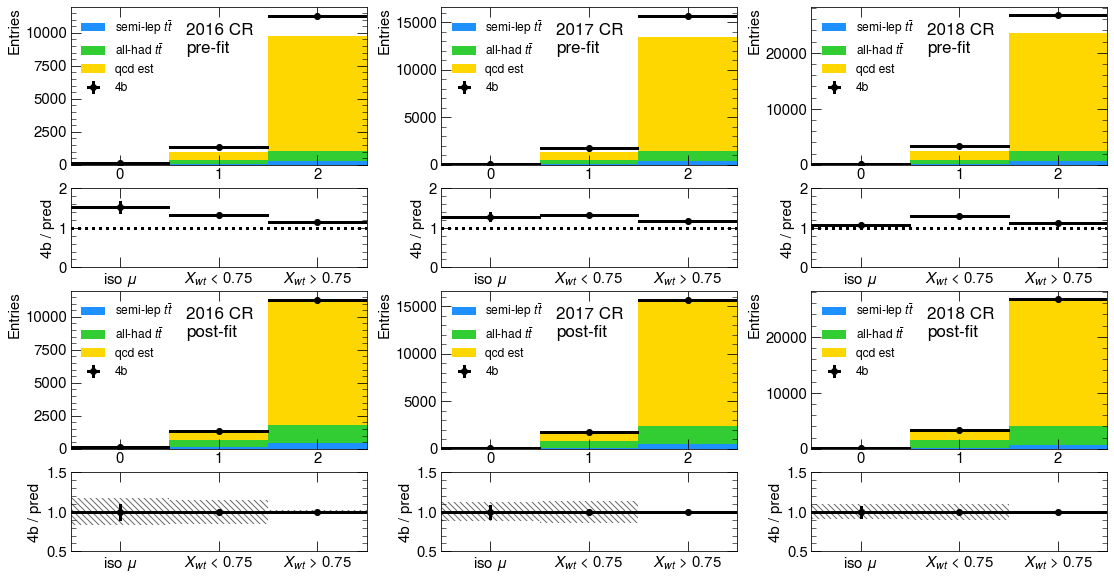

In [12]:
fitsAllYrs(hist_dict,target=bcat,rlim1=(0,2),rlim2=(0.5,1.5),figDir=figDir)

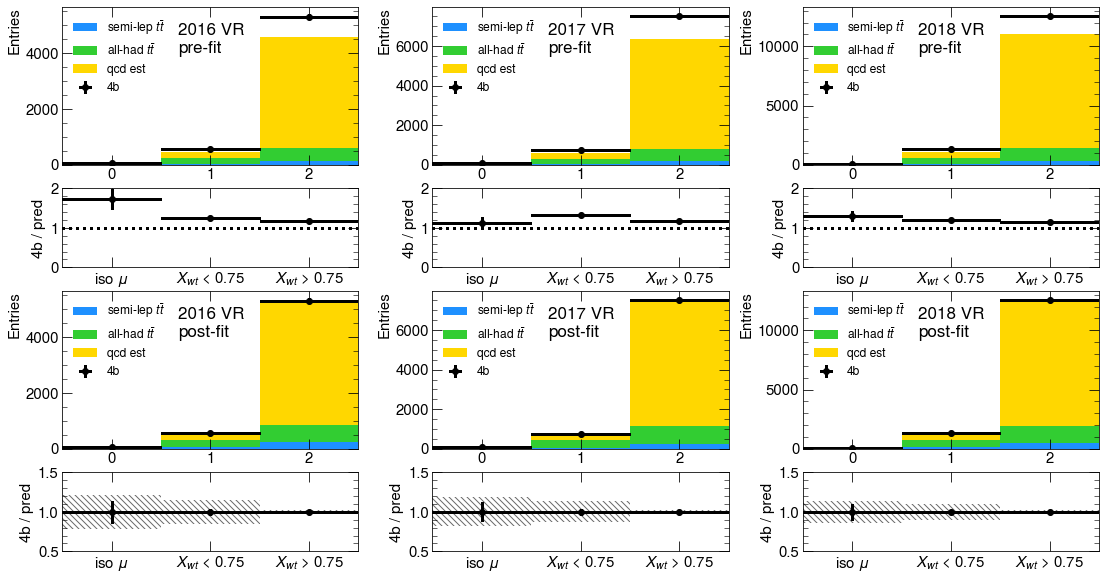

In [13]:
fitsAllYrs(hist_dict,region='vr',target=bcat,train='_vr',rlim1=(0,2),rlim2=(0.5,1.5),figDir=figDir)

### CR in VR

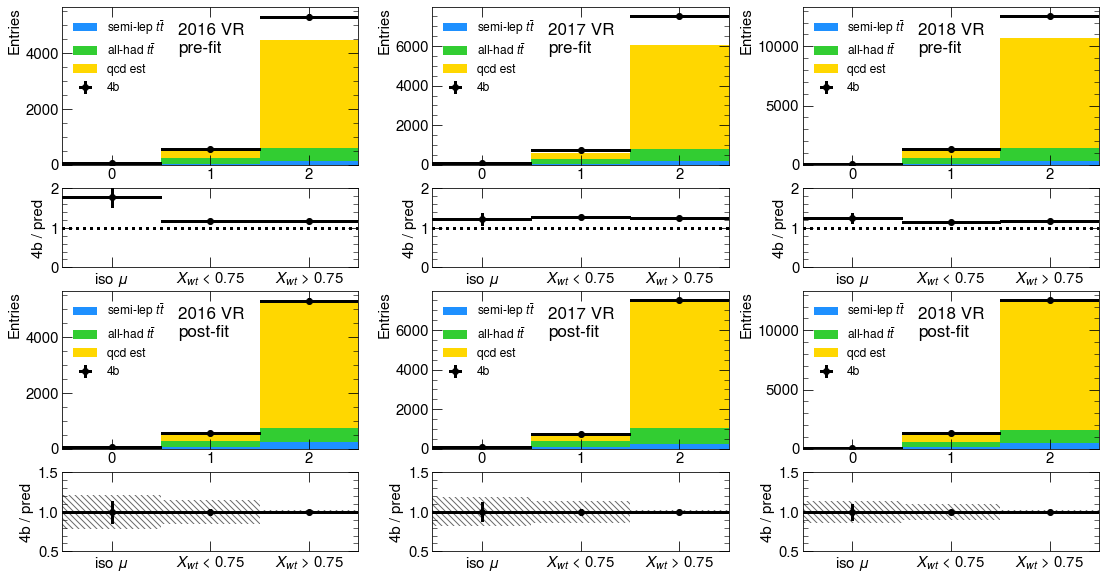

In [14]:
fitsAllYrs(hist_dict,region='vr',target=bcat,rlim1=(0,2),rlim2=(0.5,1.5),figDir=figDir)

### Correlation plots

In [32]:
p_i, cov, alpha_2b_i = getFit(hist_dict,region='cr',target=bcat,train='')

In [35]:
std = np.sqrt(np.diag(cov))
std

array([0.09661813, 0.10201978, 0.01307416])

In [41]:
np.diag(cov

array([0.00933506, 0.01040804, 0.00017093])

In [37]:
den = np.array([[std[i] * std[j] for i in range(3)] for j in range(3)])
den

array([[0.00933506, 0.00985696, 0.0012632 ],
       [0.00985696, 0.01040804, 0.00133382],
       [0.0012632 , 0.00133382, 0.00017093]])

In [46]:
def fitCorrAllYrs(histDict,cmap='bwr',figDir=''):

    
    l = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd est']
    

    fig, axes = plt.subplots(2,3,figsize=(18, 12), 
                         gridspec_kw={"height_ratios": [.5,.5],
                                      "width_ratios": [1/3,1/3,1/3],
                                      "wspace" : 0.5, #"hspace":.15,
                                     }
                        )
    
    for yr,ax_col in zip([16,17,18],axes.T):
    
        # Load in the histograms which make the fit pieces
        with open(f'{inDir}/fitCRs_{yr}_{bcat}.json') as fi:
            hist_dict = json.load(fi)

            for k in hist_dict.keys():
                hist_dict[k] = np.array(hist_dict[k])
    
        for ri, ti,ax in zip(['cr','vr'],['','_vr'],ax_col):
            # Get the fits
            p_i, cov, alpha_2b_i = getFit(hist_dict,region=ri,target=bcat,train=ti)

            # Translate from covariance to correlation
            std = np.sqrt(np.diag(cov))
            den = np.array([[std[i] * std[j] for i in range(3)] for j in range(3)])
            
            corr = cov / den
            
            
            v_abs = np.max(np.abs(corr))
            im = ax.imshow(corr,cmap=cmap,vmin=-v_abs,vmax=v_abs)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)

            ax.set_xticks(range(len(l)))
            ax.set_yticks(range(len(l)))
            ax.set_xticklabels(l,rotation=90*(1-1.2/len(l)))
            ax.set_yticklabels(l)

            # Step 3: Overlay the #s
            for i in range(len(l)):
                for j in range(len(l)):
                    cij = corr[i,j]

                    ax.text(i,j,f'{cij:.0g}',ha='center',va='center')

            ax.set_title(f'20{yr} {bcat_to_label[bcat]} {ri.upper()}',loc='left')
            ax.tick_params(which='minor', length=0)
            
    # Step 4: Save
    if figDir:
        plt.savefig(f'{figDir}/fitCorr-{bcat}-CR-VR-16-17-18.pdf', bbox_inches='tight')



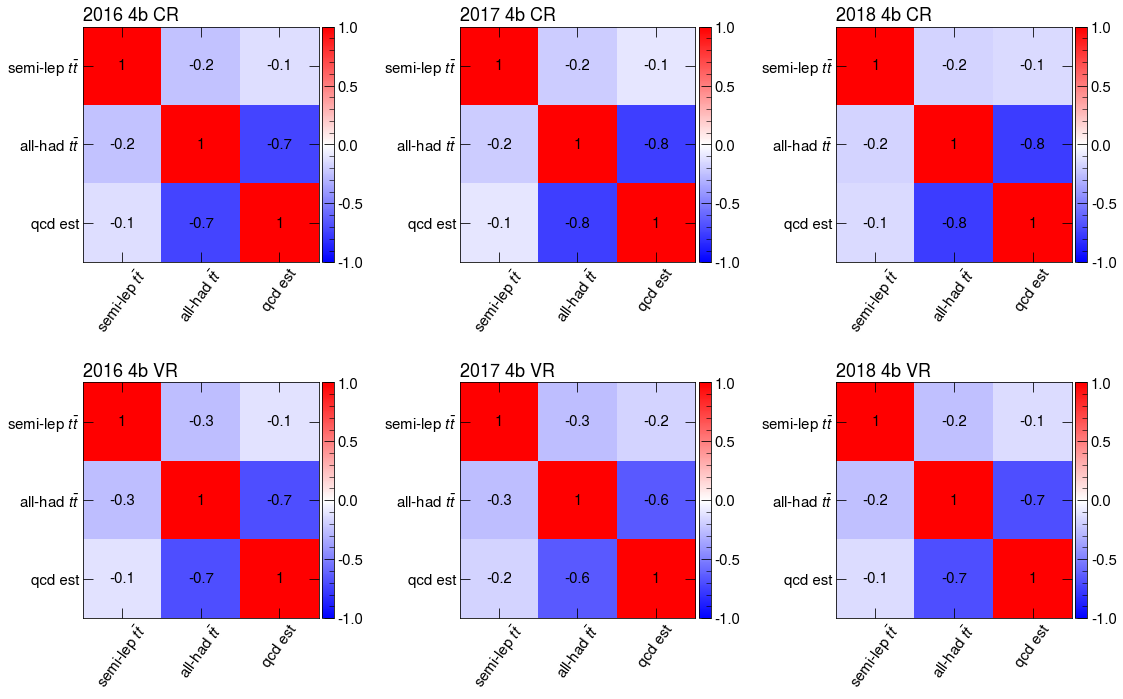

In [47]:
fitCorrAllYrs(hist_dict,figDir=figDir)

In [40]:
bcat

'4b'

In [17]:
preEst =  np.array(hist_dict[f'sl_{ri}_{bcat}']) + np.array(hist_dict[f'ah_{ri}_{bcat}']) \
                + np.array(hist_dict[f'qcd_{ri}_rw_to_{bcat}{ti}']) 
print(f'pre {ri}',yr,np.array(hist_dict['dat_cr_4b']) / preEst)

pre vr 18 [2.50914702 2.95155007 2.42397587]


### Fill out the SF table

Ok - to fill out the *last bit* of this table - I think it might be fastest to just load in the workspaces?

In [18]:
with open(f'{inDir}/ws-{bcat}-systs-HTcut-300.0-16-17-18-SM-HH-norm.json') as fi:
    ws = json.load(fi)

for yr, chan in zip([16,17,18],ws['channels']):
    
    sfs.loc['extrap norm (naive)',(yr,'QCD')] = chan['samples'][1]['modifiers'][-1]['data']['hi']

In [19]:
with open(f'{inDir}/ws-{bcat}-systs-HTcut-300.0-16-17-18-SM-HH-resNorm.json') as fi:
    ws = json.load(fi)

for yr, chan in zip([16,17,18],ws['channels']):
    
    sfs.loc['res style norm',(yr,'QCD')] = chan['samples'][1]['modifiers'][-1]['data']['hi']

In [20]:
with open(f'{inDir}/ws-{bcat}-systs-HTcut-300.0-16-17-18-SM-HH-ttbarComp.json') as fi:
    ws = json.load(fi)

for yr, chan in zip([16,17,18],ws['channels']):
    
    print(chan['samples'][3]['modifiers'][-1]['name'],chan['samples'][3]['modifiers'][-1]['data']['hi'])
    print(chan['samples'][2]['modifiers'][-1]['name'],chan['samples'][2]['modifiers'][-1]['data']['hi'])
    print(chan['samples'][1]['modifiers'][-1]['name'],chan['samples'][1]['modifiers'][-1]['data']['hi'])
    
    #sfs.loc['extrap norm (naive)'] = chan['samples'][1]['modifiers'][-1]['data']['hi']

sl_norm16_4b 1.0543183160771308
ah_norm16_4b 0.7644657287160238
bkg_norm16_4b 1.0471742708166145
sl_norm17_4b 0.8712974546032034
ah_norm17_4b 0.8633361146756569
bkg_norm17_4b 1.1080711132296563
sl_norm18_4b 1.2386405482750558
ah_norm18_4b 0.7084724268388668
bkg_norm18_4b 1.087828360910991


In [21]:
with open(f'{inDir}/ws-{bcat}-systs-HTcut-300.0-16-17-18-SM-HH-ttbarNoNorm.json') as fi:
    ws = json.load(fi)

for yr, chan in zip([16,17,18],ws['channels']):
    
    print(chan['samples'][3]['modifiers'][-1]['name'],chan['samples'][3]['modifiers'][-1]['data']['hi'])
    print(chan['samples'][2]['modifiers'][-1]['name'],chan['samples'][2]['modifiers'][-1]['data']['hi'])
    print(chan['samples'][1]['modifiers'][-1]['name'],chan['samples'][1]['modifiers'][-1]['data']['hi'])
    
    #sfs.loc['extrap norm (naive)'] = chan['samples'][1]['modifiers'][-1]['data']['hi']

sl_norm16_4b 1.0543183160771308
ah_norm16_4b 0.7644657287160238
bkg_norm16_4b 1.0355322271342453
sl_norm17_4b 0.8712974546032034
ah_norm17_4b 0.8633361146756569
bkg_norm17_4b 1.0365271868852242
sl_norm18_4b 1.2386405482750558
ah_norm18_4b 0.7084724268388668
bkg_norm18_4b 1.038451458470074


In [22]:
idx_short = ['post cr', 'post vr', 'extrap norm (new)',
             'extrap norm (naive)', 'res style norm']

In [23]:
sfs.loc[idx_short] #.round(3)

16                                    \
                            semi-lep          all-had              QCD   
post cr              1.57 $\pm$ 0.17  1.72 $\pm$ 0.15  1.09 $\pm$ 0.02   
post vr              1.65 $\pm$ 0.21  1.31 $\pm$ 0.15  1.13 $\pm$ 0.03   
extrap norm (new)           1.054318         0.764466         1.035532   
extrap norm (naive)              0.0              0.0         0.992692   
res style norm                   0.0              0.0         1.003852   

                                  17                                    \
                            semi-lep          all-had              QCD   
post cr              1.28 $\pm$ 0.12  1.83 $\pm$ 0.14  1.11 $\pm$ 0.02   
post vr              1.12 $\pm$ 0.18  1.58 $\pm$ 0.13  1.15 $\pm$ 0.02   
extrap norm (new)           0.871297         0.863336         1.036527   
extrap norm (naive)              0.0              0.0           0.9374   
res style norm                   0.0              0.0         1.002101   

                                  18                                    
                            semi-lep          all-had              QCD  
post cr              1.06 $\pm$ 0.10  1.85 $\pm$ 0.10  1.08 $\pm$ 0.01  
post vr              1.31 $\pm$ 0.14  1.31 $\pm$ 0.10  1.12 $\pm$ 0.02  
extrap norm (new)           1.238641         0.708472         1.038451  
extrap norm (naive)              0.0              0.0         0.958037  
res style norm                   0.0              0.0          1.00359

In [24]:
alpha_2b.round(3).values

array([[0.851, 0.794, 0.799],
       [0.829, 0.821, 0.833]])

**Load in the dfs**

In [25]:
fDir = '../data/RR/cryptotuples/ggF_rw_pre_Xwt/'

In [26]:
trees = ['control', 'validation', 'sig']
keys  = ['cr', 'vr', 'sr']

In [27]:
wl = get_wlab(bcat)
bl = '' if bcat=='4b' else f'_{bcat}'

In [28]:
base_cols = ['m_hh','X_wt_tag','dEta_hh','njets','pass_vbf_sel','ntag'] 

if '3b' in bcat: base_cols += ['minQ']

In [29]:
if bcat == '4b':
    expr=f'rw_to_{bcat}|ntag>=4|~pass_vbf_sel'
else:
    raise NotImplementedError

In [30]:
from utils import lumi as L

In [31]:
for yr,mc in zip([16,17,18],['mc16a','mc16d','mc16e']):

    # Add the bkg est cols
    cols = base_cols + [f'rw_to_{bcat}',
                        f'NN_{wl}_weight_bstrap_med_{yr}', 
                        f'NN_{wl}_weight_bstrap_IQR_{yr}', 
                        f'NN_{wl}_weight_VRderiv_bstrap_med_{yr}']
    
    dat_name = f'{fDir}/data{yr}_NN_100_bootstraps.root'
    ah_name  = f'{fDir}/NanoNTuple_allhad_{mc}_NN_100_bootstraps.root'
    sl_name  = f'{fDir}/NanoNTuple_semilep_{mc}_NN_100_bootstraps.root'

    dat[yr] = {k: uproot.open(f'{dat_name}:{t}').arrays(cols,           library='pd') for k,t in zip(keys,trees)}
    ah[yr]  = {k: uproot.open(f'{ ah_name}:{t}').arrays(cols+['mc_sf'], library='pd') for k,t in zip(keys,trees)}
    sl[yr]  = {k: uproot.open(f'{ sl_name}:{t}').arrays(cols+['mc_sf'], library='pd') for k,t in zip(keys,trees)}

    for k in keys:
        ah[yr][k]['mc_sf'] *= L[yr]
        sl[yr][k]['mc_sf'] *= L[yr]

        
    with uproot.open(f'{dat_name}') as fd:
        

        norm = fd[f'NN_norm{bl}_bstrap_med_{yr}'].all_members['fVal']
        norm_VR = fd[f'NN_norm{bl}_bstrap_med_{yr}'].all_members['fVal']
        norm_IQR = fd[f'NN_norm{bl}_bstrap_IQR_{yr}'].all_members['fVal']
    
    dat[yr]['norm']     = norm
    dat[yr]['norm_VR']  = norm_VR
    dat[yr]['norm_IQR'] = norm_IQR

NameError: name 'dat' is not defined

## Variable modelling (marginals)

**Q:** Does this additional flexibiltiy help us model some of these "suspicious" variables better??

**Suggestion from Sean:** Add an error bar on these plots

**Another idea:** I could plot the *pulls* b/c this is really smth that we're interested in is whether we get a better normalization with this method than the other method?

In [ ]:
alpha_2b

In [ ]:
sfs

In [ ]:
inDir

<!-- - sfs:
- alpha_2b:
- yr:
sfs, alpha_2b,  -->

In [ ]:
def marginalComponents(dat_dict, ah_dict, sl_dict, hist_dict, yr,bcat='3b1f',
                       key='sr',fit='cr',train='',
                       col='m_hh',e=np.linspace(200,1200,41),
                       unblind=False,figDir=''):
    '''
    Plot the 1d distribution comparing the background estimate broken down by
    components with the nominal (inclusive) background estimate.

    Inputs:
    - dat_dict:
    - ah_dic:
    - sl_dict:
    - hist_dict: (not necessary if I pass the sfs and alpha_2b dfs w/ the yr)
    - yr
    '''

    # Retrieve the right dfs and weights
    dat = dat_dict[key]
    ah  = ah_dict[ key]
    sl  = sl_dict[ key]
    
    norm    = dat_dict['norm']
    norm_VR = dat_dict['norm']
    normIQR = dat_dict['norm']
    
    
    '''
    Histogram setup
    '''
    
    # Get the bkg est weight
    if train == '':
        w_col = f'NN_{wl}_weight_bstrap_med_{yr}'
        ti = ''  
        
        p, _, alpha_2b = getFit(hist_dict,region=fit,target=bcat,train=train)
        
    elif train == '_vr':
        w_col = f'NN_{wl}_weight_VRderiv_bstrap_med_{yr}'
        ti = ' (VR deriv est)'
        
        p, _, alpha_2b = getFit(hist_dict,region=fit,target=bcat,train=train)
        
    else:
        raise NotImplementedError
    
    # under / overflow
    e_uf = e.copy().astype(float)
    e_uf[0] = 0
    e_uf[-1] = np.inf
    
    
    '''
    Histogram making
    '''
    
    # Inclusive rw est
    rw_mask = dat[f'rw_to_{bcat}'] & (dat.X_wt_tag > 1.5)
    rw_incl = np.histogram(dat.loc[rw_mask,'m_hh'],e_uf, 
                           weights=norm*dat.loc[rw_mask,w_col])[0]
    
    
    # component hists
    ahi = cat_sel(ah[ah.X_wt_tag > 1.5], bcat)
    sli = cat_sel(sl[sl.X_wt_tag > 1.5], bcat)
    
    h_ah = np.histogram(ahi['m_hh'],e_uf,weights=ahi['mc_sf'])[0]
    h_sl = np.histogram(sli['m_hh'],e_uf,weights=sli['mc_sf'])[0]
    
    
    # J the QCD piece :)
    ah_mask = (ah.X_wt_tag>1.5) & (ah[f'rw_to_{bcat}'])
    sl_mask = (sl.X_wt_tag>1.5) & (sl[f'rw_to_{bcat}'])

    ah_2b = np.histogram(ah.loc[ah_mask,'m_hh'],e_uf, 
                         weights=ah.loc[ah_mask,w_col]*ah.loc[ah_mask,'mc_sf'])[0]
    sl_2b = np.histogram(sl.loc[sl_mask,'m_hh'],e_uf, 
                         weights=sl.loc[sl_mask,w_col]*sl.loc[sl_mask,'mc_sf'])[0]

    qcd = rw_incl - alpha_2b * sl_2b - ah_2b
    
    
    '''
    Plotting
    '''
    scale=1
    width = 7.75*scale
    height = 5.92*scale
    bottom = 0.09 if unblind else 0.11

    lw=4

    nPanels = 3 if unblind else 2
    height_ratios = [.6,.2,.2] if unblind else [.75,.25]
    
    fig, ax  = plt.subplots(nPanels,1,figsize=(width, height), sharex=True,
                            gridspec_kw={"height_ratios": height_ratios,
                                         "hspace":0.12, "left":0.1, "bottom":bottom})

    labels = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd est']
    colors = ['dodgerblue','limegreen','gold']
    
    xx = 0.5 * (e[1:] + e[:-1])
    w  = e[1:] - e[:-1]
    
    est = 0
    for h,pi,c,l in zip([h_sl,h_ah,qcd],p,colors,labels):

        ax[0].hist(xx,e, weights=pi*h/w,bottom=est/w,color=c,label=l)
        est+=pi*h
    
    # Overlay the inclusive rw est
    ax[0].hist(xx,e,histtype='step',color='b',lw=lw,weights=rw_incl/w,label='incl bkg est')

    ekwargs = {'lw':0,'elinewidth':lw,'marker':'o'}
    if unblind:
        
        ekwargs['color'] = 'k'
        
        dfi = cat_sel(dat[dat.X_wt_tag > 1.5], bcat)
        obs = np.histogram(dfi['m_hh'],e_uf)[0]    
        ax[0].errorbar(xx,obs/w,np.sqrt(obs)/w,label='3b+1 fail',**ekwargs)

        # Add some subpanels
        ax[1].errorbar(xx,obs/est,np.sqrt(obs)/est,**ekwargs)

        ax[1].plot(e,np.ones_like(e),color=colors[-1])

        ax[2].errorbar(xx,obs/rw_incl,np.sqrt(obs)/rw_incl,**ekwargs)
        ax[2].plot(e,np.ones_like(e),color='b')


        ax[1].set_ylabel('1 / pred')
        ax[2].set_ylabel('1 / rw')

    else:

        # Add some subpanels
        print(est/rw_incl)
        
        ax[1].plot(xx,est/rw_incl,colors[-1],marker='o',lw=0)

        ax[1].plot(e,np.ones_like(e),color='b',ls='--')

        # Plot beautification
        ax[1].set_ylabel('est / incl')
        
        
    # Plot beautification
    ax[0].set_xlim(e[0],e[-1])
    ax[0].set_title(f'crypto 2016 {bcat_to_label[bcat]} SR{ti}',loc='right')
    ax[0].legend()
    ax[0].set_ylabel('Entries / GeV',y=1,ha='right')

    for axi in ax[1:]:
        axi.set_ylim(.75,1.25)

    ax[-1].set_xlabel('$m_{HH}$ [GeV]',x=1,ha='right')
      
#     if figDir:
#         plt.savefig(f'{figDir}/m_hh_sr.pdf',bbox_inches='tight')
        

In [ ]:
marginalComponents(dat, ah, sl, hist_dict, yr,'4b',key='sr',fit='cr',train='',
                   col='m_hh')

In [ ]:
marginalComponents(dat, ah, sl, hist_dict, yr,'4b',key='sr',fit='vr',train='_vr',
                   col='m_hh')

In [ ]:
dat['cr']